In [48]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import pandas as pd

from commpy.modulation import QAMModem, PSKModem

from optic.core import parameters
from optic.tx import simpleWDMTx
from optic.dsp import pulseShape, firFilter, decimate, symbolSync
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power, hardDecision

from optic.plot import pconst
# from optic.models import phaseNoise, coherentReceiver, pdmCoherentReceiver, manakovSSF, hybrid_2x4_90deg, balancedPD, pbs, ssfm
# from optic.equalization import edc, mimoAdaptEqualizer

# from utils.plot import pconst
from utils.equalization import edc, mimoAdaptEqualizer
from utils.models import phaseNoise, coherentReceiver, pdmCoherentReceiver, manakovSSF, hybrid_2x4_90deg, balancedPD, pbs, ssfm

In [49]:
def singleEnded_PD(Ein, Rd=1):
    """
    Single-Ended photodetector

    :param Ein: IQ signal
    :param R: photodiode responsivity [A/W][scalar, default: 1 A/W]
    
    :return: detected analog signals
    """
    assert Rd > 0, "PD responsivity should be a positive scalar"

    Eout = Rd*Ein*np.conj(Ein)
    
    return Eout

In [50]:
def SEReceiver(Es, Elo, Rd=1):
    """
    Single polarization single-ended coherent receiver (SER)

    :param Es: received signal field [nparray]
    :param Elo: LO field [nparray]
    :param Rd: photodiode responsivity [A/W][scalar, default: 1 A/W]

    :return: downconverted signal after single-ended photodetector
    """
    assert Rd > 0, "PD responsivity should be a positive scalar"
    assert Es.size == Elo.size, "Es and Elo need to have the same size"

    # optical 2 x 4 90° hybrid
    Eo = hybrid_2x4_90deg(Es, Elo)
    
    E1 = 2*Eo[1,:]  # select SER port and compensation
    E2 = 2*Eo[2,:]  # select SER port and compensation
    
    R1 = singleEnded_PD(E1, Rd)
    R2 = singleEnded_PD(E2, Rd)
    
    return R1, R2

In [51]:

def DFR(R1, R2, sigLO):
    """
    Direct Field Reconstruction (DFR)

    :param R1 and R2: ouput of SER [nparray]
    :param A: local oscillator (LO) [nparray]
    
    :return sig: the inphase and quadrature components of the optical field [nparray]
    """
    A = sigLO
    
    delta = 4*R1*R2 - (R1 + R2 - 2*A**2)**2
    
    sigI = - A/2 + 1/(4*A) * (R1 - R2) + 1/(4*A) * np.sqrt(delta)
    sigQ = - A/2 - 1/(4*A) * (R1 - R2) + 1/(4*A) * np.sqrt(delta)
      
    sigOut = sigI + 1j*sigQ
    
    return sigOut

In [52]:
def IC(R1, R2, sigWDM, sigLO, N=100):
    """
    Iterative SSBI Cancellation (IC)

    :param R1 and R2: ouput of SER [nparray]
    :param sigWDM: received signal [nparray]
    :param sigLO: local oscillator (LO) [nparray]
    :param N: number of iterations [scalar]
    
    :return sigOut: the inphase and quadrature components of the optical field [nparray]
    """
   
    A = sigLO                # Oscilador Local 
    P = signal_power(sigWDM) # Potência do sinal recebido
    
    U1 = (R1 - A**2) / (4*A**2) # Definindo U1 (Mudança de Variável)
    U2 = (R2 - A**2) / (4*A**2) # Definindo U2 (Mudança de Variável)
    
    overline_I = sigWDM.real / (2*A) # Define nova variável I
    overline_Q = sigWDM.imag / (2*A) # Define nova variável Q
        
    overline_I0 = U1 - P / (4*A**2) # Estimativa Inicial de I
    overline_Q0 = U2 - P / (4*A**2) # Estimativa Inicial de Q
    e0 = overline_I0 - overline_I   # Estimativa Inicial do erro estimado

    # Inicializando variáveis de iteração
    overline_In = overline_I0 # I(n) = I(0)
    overline_Qn = overline_Q0 # Q(n) = Q(0)
    error = e0                # ▲I(n) = ▲I(0)
    
    for nSteps in range(1, N): # Loop de N laços
        overline_Inext = U1 - (overline_In**2 + overline_Qn**2) # Cálculo do valor de I(n+1)
        overline_Qnext = U2 - (overline_In**2 + overline_Qn**2) # Cálculo do valor de Q(n+1)
        
        errorNext = - error * (overline_I + overline_Q + overline_In + overline_Qn) # Cálculo do valor de ▲I(n+1)
                
        overline_In = overline_Inext # Atualiza I(n+1) para I(n)
        overline_Qn = overline_Qnext # Atualiza Q(n+1) para Q(n)
        error = errorNext            # Atualiza ▲I(n+1) para ▲I(n)
    
    overline_sigOut = (overline_In + 1j*overline_Qn) # signal IC
    sigOut = (2*A) * overline_sigOut                 # recovered signal w/ SSBI cancellation
    
    return sigOut

In [53]:
def gradientDescent(R1, R2, sigWDM, sigLO, mu = 0.05, N=150):
    """
    Gradient Descent (GD)

    :param R1 and R2: ouput of SER [nparray]
    :param sigWDM: received signal [nparray]
    :param sigLO: local oscillator (LO) [nparray]
    :param mu: step size [scalar]
    :param N: number of iterations [scalar]
    
    :return sigOut: the inphase and quadrature components of the optical field [nparray]
    """
    
    A = sigLO                # Oscilador Local 
    P = signal_power(sigWDM) # Potência do sinal recebido
    
    U1 = (R1 - A**2) / (4*A**2) # Definindo U1 (Mudança de Variável)
    U2 = (R2 - A**2) / (4*A**2) # Definindo U2 (Mudança de Variável)
    
    overline_I = sigWDM.real / (2*A) # Define nova variável I
    overline_Q = sigWDM.imag / (2*A) # Define nova variável Q
    
    overline_I0 = U1 - P / (4*A**2) # Estimativa Inicial de I
    overline_Q0 = U2 - P / (4*A**2) # Estimativa Inicial de Q
    
    # Inicializando variáveis de iteração
    overline_In = overline_I0 # I(n) = I(0)
    overline_Qn = overline_Q0 # Q(n) = Q(0)
    
    for nSteps in range(1, N): # Loop de N laços
        X_InQn = overline_In**2 + overline_Qn**2 + overline_In - U1 # Cálculo do valor de X(In,Qn)
        Y_InQn = overline_In**2 + overline_Qn**2 + overline_Qn - U2 # Cálculo do valor de Y(In,Qn)
        
        error = 2 * np.sqrt( (overline_In - overline_I)**2 + (overline_Qn - overline_Q)**2 ) # Cálculo do erro normalizado ▲V(n)

        overline_Inext = overline_In - mu * (X_InQn * (2*overline_In + 1) + 2 * Y_InQn * overline_In) # Cálculo do valor de I(n+1)
        overline_Qnext = overline_Qn - mu * (X_InQn * overline_Qn + 2 * Y_InQn * (2*overline_Qn + 1)) # Cálculo do valor de Q(n+1)
        
        overline_In = overline_Inext # Atualiza I(n+1) para I(n)
        overline_Qn = overline_Qnext # Atualiza Q(n+1) para Q(n)
        
    overline_sigOut = (overline_In + 1j*overline_Qn) # signal GD
    sigOut = (2*A) * overline_sigOut                 # recovered signal w/ SSBI cancellation
    
    return sigOut

In [54]:
# Parâmetros - Transmissor
paramTx = parameters()

paramTx.M   = 64            # Ordem do formato de modulação
paramTx.constType = 'qam'   # Formato de modulação ('qam' ou 'psk')

paramTx.Rs  = 100e9         # Taxa de sinalização [baud]
paramTx.SpS = 4             # Número de amostras por símbolo
Fs = paramTx.Rs*paramTx.SpS # Taxa de amostragem [Hz]

paramTx.Nbits = 300000  # Número total de bits por polarização

paramTx.pulse    = 'rrc'   # Tipo do filtro formatador de pulso
paramTx.Ntaps    = 1024    # Número de coeficientes do filtro
paramTx.alphaRRC = 0.01    # Rolloff do pulso RRC

paramTx.Pch_dBm  = 0       # Potência média por canal WDM [dBm]
paramTx.Nch      = 1       # Número de canais WDM
paramTx.freqSpac = 40.0e9  # Espaçamento WDM

paramTx.Fc     = 193.1e12  # Frequência central de operação
paramTx.Nmodes = 1         # Número de modos de polarização

Tx = ['Parâmetros do Transmissor:',
      '- Formato de Modulação: {}-{}' .format(paramTx.M, paramTx.constType.upper()),
      '- Taxa de Sinalização: {} Gbaud' .format(paramTx.Rs*1e-9),
      '- Taxa de Amostragem: {} GHz' .format(Fs*1e-9),
      '- Potência Média Enviada: {} dBm' .format(paramTx.Pch_dBm),
      '- Frequência de Operação: {} THz' .format(paramTx.Fc*1e-12),
      '- Número de polarizações do sinal: {}\n' .format(paramTx.Nmodes)]
for i in Tx:
    print(i)

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

Parâmetros do Transmissor:
- Formato de Modulação: 64-QAM
- Taxa de Sinalização: 100.0 Gbaud
- Taxa de Amostragem: 400.0 GHz
- Potência Média Enviada: 0 dBm
- Frequência de Operação: 193.1 THz
- Número de polarizações do sinal: 1

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm


Text(0.5, 1.0, 'optical WDM spectrum')

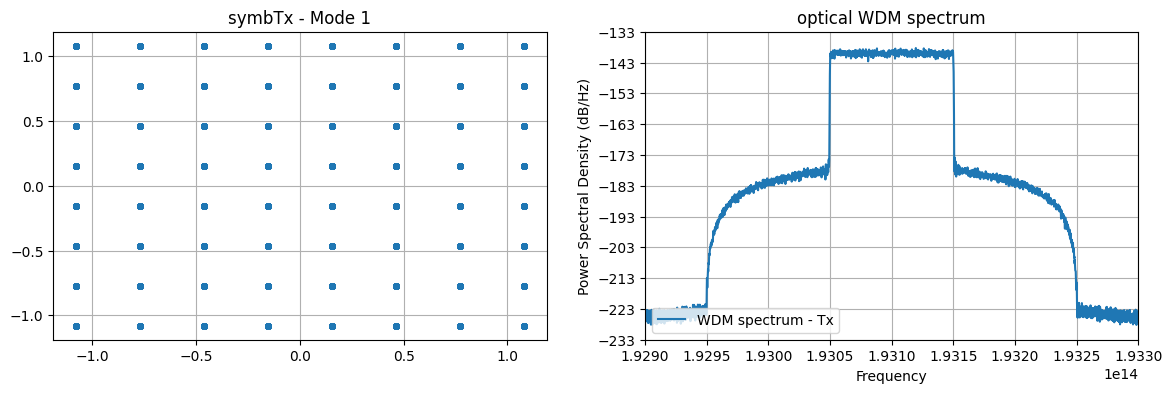

In [55]:
# plot psd and constellations (pós-geração)
fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].plot(np.squeeze(symbTx_).real, np.squeeze(symbTx_).imag,'.', markersize=7)
axs[0].set_title('symbTx - Mode 1')
axs[0].grid('True')

axs[1].psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramTx.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
axs[1].set_xlim(paramTx.Fc-Fs/2,paramTx.Fc+Fs/2)
axs[1].legend(loc='lower left')
axs[1].set_title('optical WDM spectrum')

In [56]:
# Canal Óptico
paramCh = parameters()

paramCh.Ltotal = 200     # Distância total do enlace [km]
paramCh.Lspan  = 20      # Passo da distância [km]

paramCh.alpha = 0.2      # Parâmetro de perda da fibra [dB/km]
paramCh.D = 16           # Parâmetro de dispersão da fibra [ps/nm/km]
paramCh.gamma = 1.3      # Parâmetro não-linear da fibra [1/(W.km)]

paramCh.Fc = paramTx.Fc  # Frequência da portadora do sinal WDM [Hz]
paramCh.hz = 0.1         # Step-size do SSFM [km]

if not paramCh.Ltotal:
    print('back-to-back connection.')
    sigWDM = sigWDM_Tx
    
else:
    print(f'distance: {paramCh.Ltotal:.2f} km')
    print('symmetric, single-pol.')
    sigWDM, paramCh = ssfm(sigWDM_Tx, Fs, paramCh)
    sigWDM = sigWDM.reshape(len(sigWDM),1)
    
channel = ['Enlace óptico:',
      '- Distância percorrida: {:.2f} km' .format(paramCh.Ltotal),
      '- Parâmetro de perda da fibra: {} dB/km' .format(paramCh.alpha),
      '- Parâmetro de dispersão da fibra: {} ps/nm/km' .format(paramCh.D),
      '- Parâmetro não-linear da fibra: {} 1/(W.km)\n' .format(paramCh.gamma)]


distance: 200.00 km
symmetric, single-pol.


100%|██████████| 10/10 [01:28<00:00,  8.82s/it]


Text(0.5, 1.0, 'optical WDM spectrum')

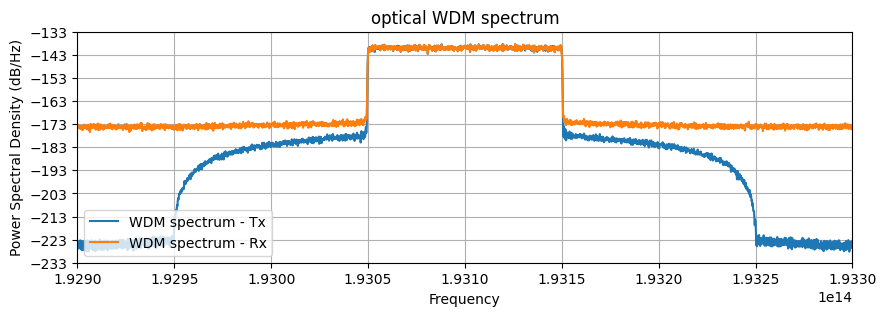

In [57]:
# plot psd
plt.figure(figsize=(10, 3))
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2)
plt.psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum')

In [58]:
# Parâmetros - Receptor
mod = QAMModem(m=paramTx.M)

chIndex  = 0     # Posição do canal WDM a ser demodulado
Fc = paramTx.Fc
Ts = 1/Fs

freqGrid = paramTx.freqGrid
print(f'Demodulating channel #{chIndex} \n',
      f'- fc: {((Fc + freqGrid[chIndex])/1e12):.4f} THz\n',
      f'- λ: {(const.c/(Fc + freqGrid[chIndex])/1e-9):.4f} nm\n')

symbTx = symbTx_[:,:,chIndex]

Demodulating channel #0 
 - fc: 193.1000 THz
 - λ: 1552.5244 nm



In [59]:
# Parâmetros - Receptor - Oscilador Local
π       = np.pi
FO      = 0*64e6                # Offset de frequência
Δf_lo   = freqGrid[chIndex]+FO  # Deslocamento de frequência do canal a ser demodulado
lw      = 0*100e3               # LineWidth
Plo_dBm = 20                    # Potência [dBm]
Plo     = 10**(Plo_dBm/10)*1e-3 # Potência [W]
ϕ_lo    = 0                     # Fase inicial [rad]    

print(f'Local oscillator\n',
      f'- Power: {Plo_dBm:.2f} dBm\n',
      f'- LineWidth: {(lw/1e3):.2f} kHz\n',
      f'- Frequency offset: {(FO/1e6):.2f} MHz')

# Geração do sinal LO
t       = np.arange(0, len(sigWDM))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

Local oscillator
 - Power: 20.00 dBm
 - LineWidth: 0.00 kHz
 - Frequency offset: 0.00 MHz


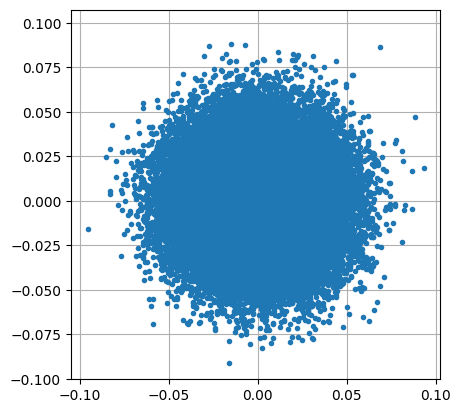

In [60]:
# Receptor óptico single-ended
sigWDM = sigWDM.reshape(len(sigWDM),)
R1, R2 = SEReceiver(sigWDM, sigLO, Rd=1)

# Mitigação da SSBI
type_EqSSBI = 'gd'

assert type_EqSSBI in ['none', 'dfr', 'ic', 'gd'], "Algoritmo de mitigação da SSBI inválido."

if type_EqSSBI == 'none':
    # Sinal recuperado após os PDs sem mitigação da SSBI
    sigPD = R1 + 1j*R2
    sigPD = sigPD - np.mean(sigPD)
    
    sigRx = sigPD
    
elif type_EqSSBI == 'dfr':
    # Algoritmo de reconstrução de sinal (DFR)
    sigDFR = DFR(R1, R2, sigLO)
    sigDFR = sigDFR - np.mean(sigDFR)

    sigRx = sigDFR

elif type_EqSSBI == 'ic':
    # Algoritmo iterativo de cancelamento da SSBI (IC)
    Nsteps = 10 # Número de iterações
    sigIC = IC(R1, R2, sigWDM, sigLO, N=Nsteps)
    
    sigRx = sigIC
    
elif type_EqSSBI == 'gd':
    # Algoritmo gradiente descendente
    mu_ = 0.05 # Passo do algoritmo
    Nsteps  = 50 # Número de iterações
    sigGD = gradientDescent(R1, R2, sigWDM, sigLO, mu=mu_, N=Nsteps)
    
    sigRx = sigGD
    
    
# plot constellations (pós-receptor coerente)
pconst(sigRx[0::paramTx.SpS], lim=False, R=3)

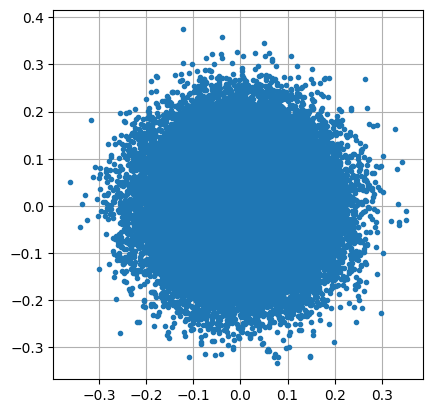

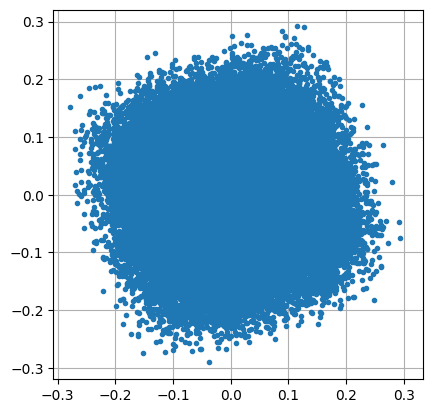

In [61]:
# Filtro casado
pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
pulse = pulse/np.max(np.abs(pulse))

sigRx = firFilter(pulse, sigRx)
    
# plot constellations (pós-filtragem)
pconst(sigRx[0::paramTx.SpS], lim=False, R=3)

# Compensação da disperção cromática
if paramCh.Ltotal:
    sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fs)
    
    # plot constellations (pós-filtragem+compensação)
    pconst(sigRx[0::paramTx.SpS], lim=False, R=3)

In [62]:
# Redução de amostras por símbolos
paramDec = parameters()

paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2

sigRx = sigRx.reshape(len(sigRx), 1)
sigRx = decimate(sigRx, paramDec)
symbRx = symbolSync(sigRx, symbTx, 2)

In [63]:
x = sigRx
d = symbRx

x = x.reshape(len(x),1)/np.sqrt(signal_power(x))
d = d.reshape(len(d),1)/np.sqrt(signal_power(d))

[10000, 40000]


nlms - training stage #0


 60%|██████    | 3/5 [00:00<00:00, 25.86it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.017400.
nlms pre-convergence training iteration #1
nlms MSE = 0.002534.
nlms pre-convergence training iteration #2
nlms MSE = 0.002314.
nlms pre-convergence training iteration #3
nlms MSE = 0.002245.
nlms pre-convergence training iteration #4


100%|██████████| 5/5 [00:00<00:00, 23.47it/s]

nlms MSE = 0.002223.


da-rde - training stage #1


da-rde MSE = 0.004173.


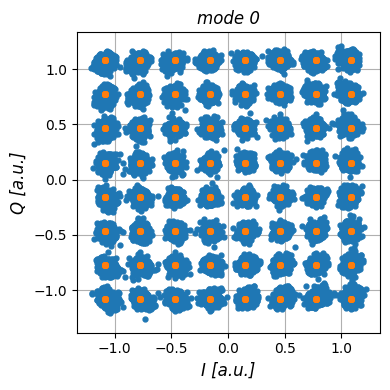

In [64]:
# Algoritmo de Equalização
paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS   = 2
paramEq.mu    = [3e-3, 4e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg   = ['nlms','da-rde']
paramEq.M     = paramTx.M
paramEq.L = [int(0.20*len(x)/2), int(0.80*len(x)/2)]
print(paramEq.L)

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

# plot constellations (pós-equalização)
discard = 5000
plt.figure(figsize=(4,4))
plt.plot(np.squeeze(y_EQ[discard:-discard,:]).real, np.squeeze(y_EQ[discard:-discard,:]).imag,'.', markersize=7)
plt.plot(np.squeeze(d).real, np.squeeze(d).imag,'.', markersize=7)
plt.title('mode 0', fontsize=12.0, fontstyle='oblique')
plt.xlabel('I [a.u.]', fontsize=12.0, fontstyle='oblique')
plt.ylabel('Q [a.u.]', fontsize=12.0, fontstyle='oblique')
plt.grid()
plt.tight_layout()
plt.show()

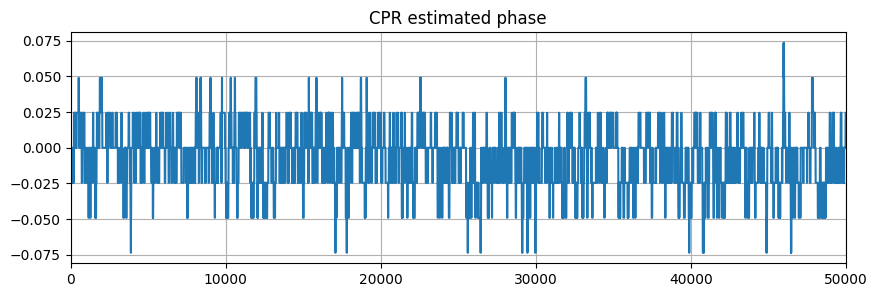

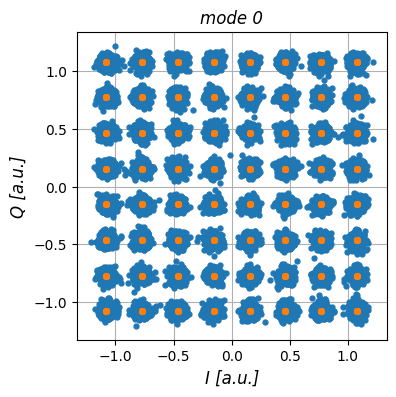

In [65]:
# Algoritmo de Recuperação de Fase
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 35
paramCPR.B   = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20) 

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

plt.figure(figsize=(10, 3))
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid()

# plot constellations (pós-CPR)
discard = 5000
plt.figure(figsize=(4,4))
plt.plot(np.squeeze(y_CPR[discard:-discard,:]).real, np.squeeze(y_CPR[discard:-discard,:]).imag,'.', markersize=7)
plt.plot(np.squeeze(d).real, np.squeeze(d).imag,'.', markersize=7)
plt.title('mode 0', fontsize=12.0, fontstyle='oblique')
plt.xlabel('I [a.u.]', fontsize=12.0, fontstyle='oblique')
plt.ylabel('Q [a.u.]', fontsize=12.0, fontstyle='oblique')
plt.grid()
plt.show()

In [66]:
# correct (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:,k]/y_CPR[:,k])
    y_CPR[:,k] = rot*y_CPR[:,k]

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))


ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
GMI,_    = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')

polx = [SER[0],BER[0],SNR[0],MI[0],GMI[0]]
results = np.array([polx])

for i in Tx:
    print(i)
for i in channel:
    print(i)

df2 = pd.DataFrame(results, index=['Pol. X'], columns=['BER', 'SER', 'SNR [dB]', 'GMI [bits]', 'MI [bits]'])
df2.style.format({"BER": "{:.2e}", "SER": "{:.2e}", "SNR [dB]": "{:.2f}", "GMI [bits]": "{:.2f}", "MI [bits]": "{:.2f}"})

Parâmetros do Transmissor:
- Formato de Modulação: 64-QAM
- Taxa de Sinalização: 100.0 Gbaud
- Taxa de Amostragem: 400.0 GHz
- Potência Média Enviada: 0 dBm
- Frequência de Operação: 193.1 THz
- Número de polarizações do sinal: 1

Enlace óptico:
- Distância percorrida: 200.00 km
- Parâmetro de perda da fibra: 0.2 dB/km
- Parâmetro de dispersão da fibra: 16 ps/nm/km
- Parâmetro não-linear da fibra: 1.3 1/(W.km)



,BER,SER,SNR [dB],GMI [bits],MI [bits]
Pol. X,2.75e-04,4.58e-05,27.04,6.00,6.00
